In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
from scipy.special import logit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic, binned_statistic_2d, pearsonr, linregress
from global_land_mask import globe
from src.regions import *
from src.pf_stats import *
from src.plotting import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

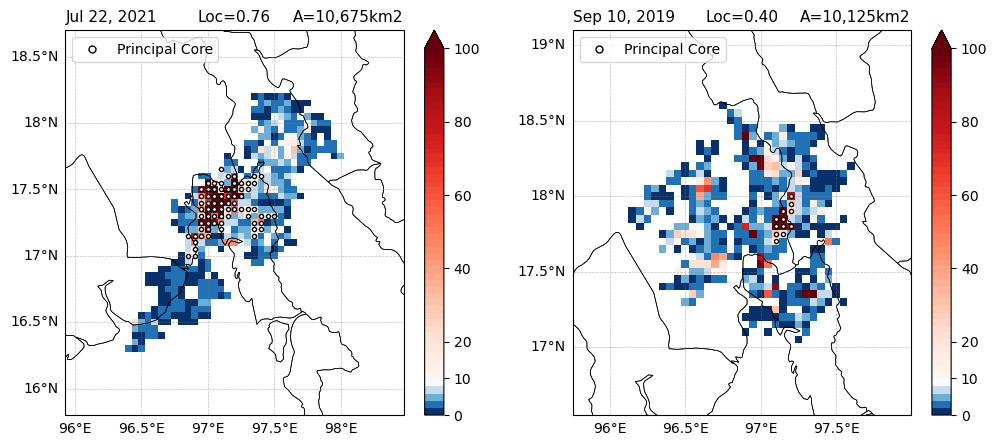

In [6]:
# Make colormap for features
def create_split_cmap(vmin=0, vmax=100, split=10,
                      cmap_low=plt.cm.Blues, cmap_high=plt.cm.Reds):
    """
    Create a custom colormap transitioning from cmap_low to cmap_high
    with 'split' as the boundary.
    """
    fraction = (split - vmin) / (vmax - vmin)
    n_total = 256
    n_low = int(n_total * fraction)
    n_high = n_total - n_low
    colors_low = cmap_low(np.linspace(0, 1, n_low))
    colors_high = cmap_high(np.linspace(0, 1, n_high))
    merged_colors = np.vstack((colors_low, colors_high))
    split_cmap = colors.ListedColormap(merged_colors, name="BluesToReds")
    split_norm = colors.Normalize(vmin=vmin, vmax=vmax)
    return split_cmap, split_norm


cmap_split, norm_split = create_split_cmap(
    vmin=0,
    vmax=100,
    split=10,
    cmap_low=make_discrete_cmap(plt.cm.Blues_r, 5),
    cmap_high=make_discrete_cmap(plt.cm.Reds, 50)
)

fig, axs = plt.subplots(
    ncols=2,
    figsize=(12, 5),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# We'll plot two examples: 'high_area_high_loc' and 'high_area_low_loc'
regimes = ['high_area_high_loc', 'high_area_low_loc']
for i, (ax_map, regime) in enumerate(zip(axs.ravel(), regimes)):
    # Ensure we keep a 1:1 lat/lon aspect ratio on both maps
    ax_map.set_aspect('equal', adjustable='datalim')

    # Load the example dataset
    pf_filename = f'/Users/pedro/extreme_precipitation_in_gpm/data/example_data/{regime}.nc'
    pf_data = xr.open_dataset(pf_filename)

    # Plot near_surf_rain
    rain_plot = pf_data.near_surf_rain.plot(
        ax=ax_map,
        cmap=cmap_split,
        norm=norm_split,
        cbar_kwargs={'label': None, 'ticks': [0, 10, 20, 40, 60, 80, 100] },
        transform=ccrs.PlateCarree()
    )

    lon = pf_data['lon'].values   
    lat = pf_data['lat'].values
    
    # Zoom to data
    buffer = 0.5
    ax_map.set_extent([lon.min()-buffer, lon.max()+buffer, lat.min()-buffer, lat.max()+buffer], ccrs.PlateCarree())

    # Label connected regions where rain > 10 mm/hr
    rain = pf_data.near_surf_rain.values
    mask = (rain > 10)
    structure = np.ones((3, 3))  # 8-connected
    labeled_array, num_features = ndimage.label(mask, structure=structure)

    if num_features > 0:
        region_sizes = ndimage.sum(mask, labeled_array, index=np.arange(1, num_features + 1))
        largest_region_label = np.argmax(region_sizes) + 1
        largest_region_mask = (labeled_array == largest_region_label)
        indices = np.argwhere(largest_region_mask)

        # Plot a marker for each cell in largest region
        for (i_idx, j_idx) in indices:
            ax_map.plot(
                lon[j_idx], lat[i_idx],
                marker='o', color='white', markersize=3, markeredgecolor='black',
                transform=ccrs.PlateCarree()
            )
        legend_handle = Line2D([], [], marker='o', linestyle='None',
                       markerfacecolor='white', markeredgecolor='black',
                       markersize=5, label='Principal Core')
        ax_map.legend(handles=[legend_handle], loc='upper left')

    # Some features on the map
    ax_map.add_feature(cfeature.STATES, linewidth=0.5)
    ax_map.add_feature(cfeature.COASTLINE, linewidth=0.5)

    # Add quarter-degree lat/lon gridlines and labels
    gl = ax_map.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5,
        color='gray',
        alpha=0.5,
        linestyle='--'
    )
    # Turn off top/right labels if desired
    gl.top_labels = False
    gl.right_labels = False

    # Quarter-degree ticks
    gl.xlocator = mticker.MultipleLocator(0.5)
    gl.ylocator = mticker.MultipleLocator(0.5)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Panel labeling
    ax_map.set_title('')
    # ax_map.set_title(chr(ord('A') + i), loc='left')

    # Title with date
    time_label = pf_data.time.dt.strftime('%b %d, %Y').item()
    ax_map.set_title(time_label, loc='left', fontsize=11)

    # Right-side subtitle with lambda and size
    area = (~(np.isnan(pf_data.near_surf_rain))).sum()*25

    lambda_val = [0.76, 0.40][i]  # HARDCODED VALUES FOR PLOTTING
    ax_map.set_title(rf'Loc={lambda_val:.2f}', loc='center', fontsize=11)
    ax_map.set_title(rf'A={area:,}km2', loc='right', fontsize=11)

save_figure(fig, 'Example PFs')